# General rundown
This notebook details the construction of the $C_\ell$ data vector for use in the main analysis, as well as the construction of the derivative vectors with respect to each cosmological parameter. Intitial forecasting is then done using the chainconsumer python library (big triangle plots)

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt

In [2]:
params_fiducial_test = {'Omega_c': 0.27,\
                           'Omega_b': 0.045,\
                           'h': 0.67,\
                           'A_s_norm': 2.1,\
                           'n_s': 0.96,\
                           'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
                           'w0': -0.9,\
                           'wa': 0,\
                           'mu_0': 0,\
                           'sigma_0': 0 }

In [3]:
def data_vector(params):
    '''This function takes a parameter argument which is a list of dictionaries used to vary one specific parameter,
    it then calculates the data vectors for each dict and plots them on the same matplotlib figure, allowing for the
    effects of varying each cosmological parameter on the data vectors form to be analysed'''
    
    cosmo = ccl.Cosmology(Omega_c = params['Omega_c'],\
                          Omega_b = params['Omega_b'],\
                          h = params['h'],\
                          A_s = params['A_s_norm']*10**(-9),\
                          n_s = params['n_s'],\
                          w0 = params['w0'],\
                          wa = params['wa'],\
                          mu_0 = params['mu_0'],\
                          sigma_0 = params['sigma_0'],\
                          matter_power_spectrum = 'linear')
    
    #Load in lensing and clustering distributions and ell
    dNdz_lens = np.loadtxt('dNdz_srcs_LSSTSRD_Y1.dat') 
    dNdz_clust = np.loadtxt('dNdz_clust_LSSTSRD_Y1.dat')
    ell = np.loadtxt('ell-values')
    
    #Construct tracer objects
    tracers_clust = []
    tracers_lens = []
    
    for i in range(5):
        tracers_clust.append(ccl.NumberCountsTracer(cosmo,\
                                                    has_rsd=False,\
                                                    dndz=(dNdz_clust[:,0],\
                                                    dNdz_clust[:,i+1]),\
                                                    bias=(dNdz_clust[:,0], params['bias'][i]*np.ones(2000))))
    
        tracers_lens.append(ccl.WeakLensingTracer(cosmo, dndz=(dNdz_lens[:,0], dNdz_lens[:,i+1])))
    
    #Now that the tracers are constructed, calculate C_l's for shear, gg-lensing and lensing
    cls_clus = []
    cls_gg = []
    cls_gg_clean = []
    gglensing = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    cls_lens = []
    

    for i in range(len(tracers_clust)):
        
        cls_clus.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_clust[i], ell))
        
        for j in range(len(tracers_clust)):
            
            cls_gg.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_lens[j], ell))
            
            if i >= j:
                cls_lens.append(ccl.angular_cl(cosmo,tracers_lens[i], tracers_lens[j], ell))
                
    for n in range(len(gglensing)):
        if gglensing[n] == 1:
            cls_gg_clean.append(cls_gg[n])

    #Clean up the data vectors shapes and combine them all
    cls_clus_gg = np.append(cls_clus, cls_gg_clean)
    cls_combined = np.append(cls_clus_gg, cls_lens)
    
    return cls_combined

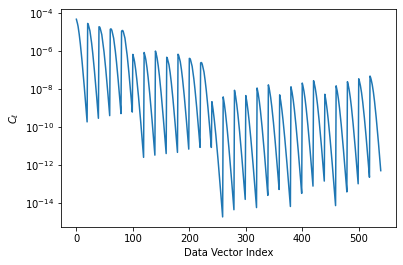

In [4]:
#Check that the data vector is looking as it should be (in comparison to the LSST one)

data_vector_fiducial = data_vector(params_fiducial_test)

plt.plot(data_vector_fiducial)
plt.yscale('log')
plt.ylabel('$C_\ell$')
plt.xlabel('Data Vector Index')
plt.show()

### Finite difference method to calculate the numerical derivative data vectors (should be 540 long)

In [5]:
def numerical_deriv(param,h):
    '''This function takes a parameter "param" and a value for h to calculate the numerical derivative with respect to param of
    each index of the c_ell value data vector. Note - h is as a percentage of the fiducial value of the parameter "param"'''
    if type(param) != str:
        print('Please input a parameter name as a string')

    if h <= 0:
        print('Please input a positive value for h')
        
    #Define the fiducial parameters for the model that will be varied by h
    if param == 'mu_0' or param == 'sigma_0' or param == 'wa':
        params_fiducial = {'Omega_c': 0.27,\
                            'Omega_b': 0.045,\
                            'h': 0.67,\
                            'A_s_norm': 2.1,\
                            'n_s': 0.96,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.1,\
                            'mu_0': 0.1,\
                            'sigma_0': 0.1 }
    else:
        params_fiducial = {'Omega_c': 0.27,\
                            'Omega_b': 0.045,\
                            'h': 0.67,\
                            'A_s_norm': 2.1,\
                            'n_s': 0.96,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.0,\
                            'mu_0': 0.0,\
                            'sigma_0': 0.0 }

    #Create a dictionary list that varies the specified parameter by -2h,-h,h,2h
    
    params_pos2h  = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_posh = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_negh = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_neg2h = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    if param == 'bias_1':
        params_pos2h['bias'][0] += 2*h*params_fiducial['bias'][0]
        
        params_posh['bias'][0] += h*params_fiducial['bias'][0]
        
        params_negh['bias'][0] -= h*params_fiducial['bias'][0]
        
        params_neg2h['bias'][0] -= 2*h*params_fiducial['bias'][0]
        
    elif param == 'bias_2':
        params_pos2h['bias'][1] += 2*h*params_fiducial['bias'][1]
        
        params_posh['bias'][1] += h*params_fiducial['bias'][1]
        
        params_negh['bias'][1] -= h*params_fiducial['bias'][1]
        
        params_neg2h['bias'][1] -= 2*h*params_fiducial['bias'][1]
        
    elif param == 'bias_3':
        params_pos2h['bias'][2] += 2*h*params_fiducial['bias'][2]
        
        params_posh['bias'][2] += h*params_fiducial['bias'][2]
        
        params_negh['bias'][2] -= h*params_fiducial['bias'][2]
        
        params_neg2h['bias'][2] -= 2*h*params_fiducial['bias'][2]
        
    elif param == 'bias_4':
        params_pos2h['bias'][3] += 2*h*params_fiducial['bias'][3]
        
        params_posh['bias'][3] += h*params_fiducial['bias'][3]
        
        params_negh['bias'][3] -= h*params_fiducial['bias'][3]
        
        params_neg2h['bias'][3] -= 2*h*params_fiducial['bias'][3]
        
    elif param == 'bias_5':
        params_pos2h['bias'][4] += 2*h*params_fiducial['bias'][4]
        
        params_posh['bias'][4] += h*params_fiducial['bias'][4]
        
        params_negh['bias'][4] -= h*params_fiducial['bias'][4]
        
        params_neg2h['bias'][4] -= 2*h*params_fiducial['bias'][4]
    
    
    else:
        params_pos2h[f"{param}"] += 2*h*params_fiducial[f"{param}"]
    
        params_posh[f"{param}"] += h*params_fiducial[f"{param}"]
    
        params_negh[f"{param}"] -= h*params_fiducial[f"{param}"]
    
        params_neg2h[f"{param}"] -= 2*h*params_fiducial[f"{param}"]

    #Now we work on calculating the numerical derivative of the data vector wrt "param"
    parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h))

    return parameter_deriv_vector

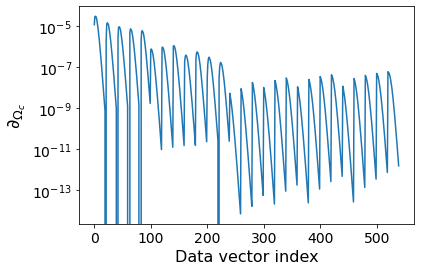

In [7]:
Omega_c_deriv = numerical_deriv('Omega_c', 0.01)

plt.plot(Omega_c_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{\Omega_c}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

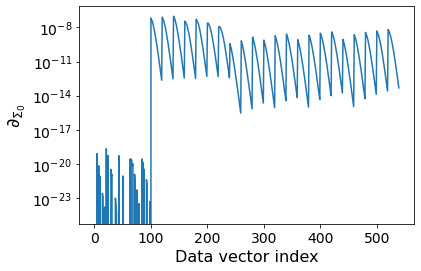

In [8]:
sig_0_deriv = numerical_deriv('sigma_0', 0.01)

plt.plot(sig_0_deriv)
plt.plot()
plt.yscale('log')
plt.ylabel('$\partial_{\Sigma_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

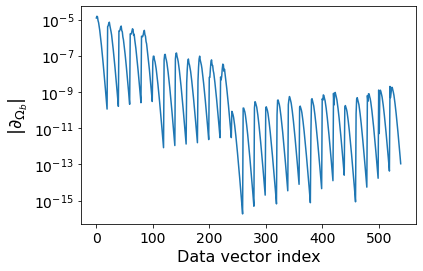

In [9]:
Omega_b_deriv = numerical_deriv('Omega_b', 0.01)

plt.plot(np.abs(Omega_b_deriv))
plt.yscale('log')
plt.ylabel('$|\partial_{\Omega_b}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

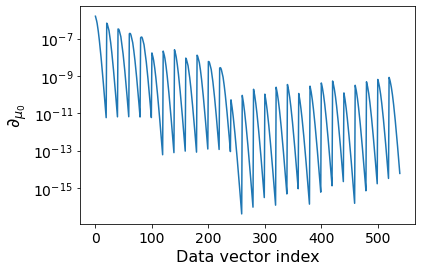

In [10]:
mu_0_deriv= numerical_deriv('mu_0', 0.01)

plt.plot(mu_0_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{\mu_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

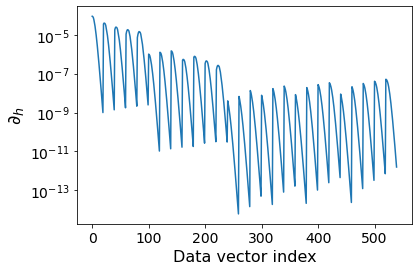

In [11]:
h_deriv = numerical_deriv('h', 0.01)

plt.plot(h_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{h}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

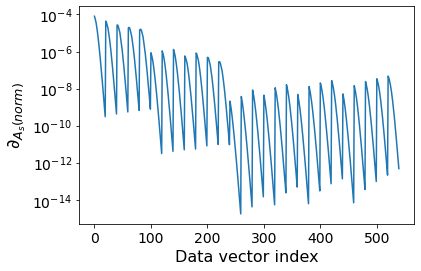

In [12]:
A_s_norm_deriv = numerical_deriv('A_s_norm', 0.01 )

plt.plot(A_s_norm_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{A_s(norm)}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

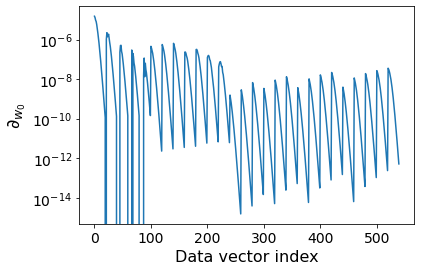

In [13]:
w0_deriv = numerical_deriv('w0', 0.01)

plt.plot(w0_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{w_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

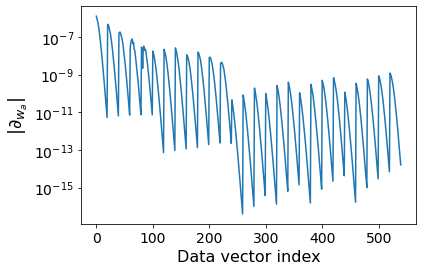

In [14]:
wa_deriv = numerical_deriv('wa', 0.01)

plt.plot(np.abs(wa_deriv))
plt.yscale('log')
plt.ylabel('$|\partial_{w_a}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

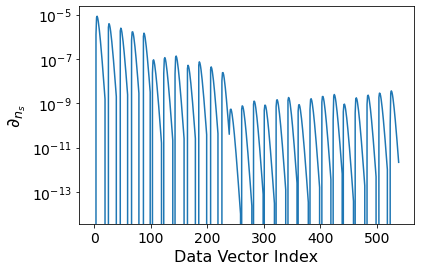

In [15]:
n_s_deriv = numerical_deriv('n_s', 0.01)

plt.plot(n_s_deriv)
plt.xlabel('Data Vector Index', fontsize = 16)
plt.ylabel('$\partial_{n_s}$', fontsize = 18)
plt.yscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

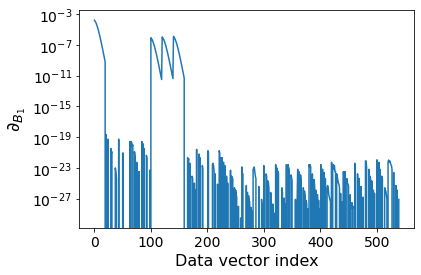

In [16]:
bias_1_deriv = numerical_deriv('bias_1', 0.01)

plt.plot(bias_1_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_1}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

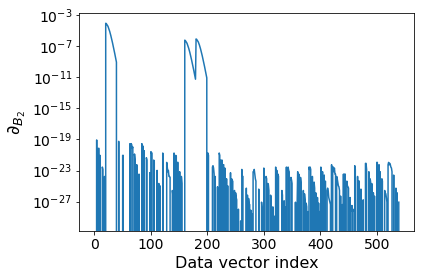

In [17]:
bias_2_deriv = numerical_deriv('bias_2', 0.01)

plt.plot(bias_2_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_2}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

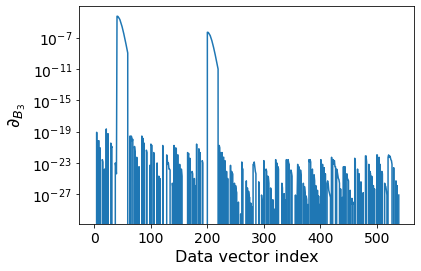

In [18]:
bias_3_deriv = numerical_deriv('bias_3', 0.01)

plt.plot(bias_3_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_3}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

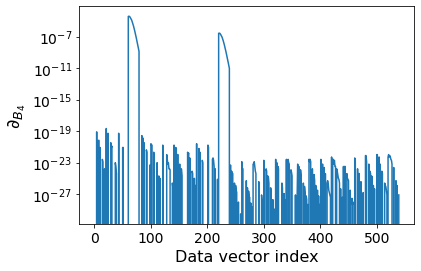

In [19]:
bias_4_deriv = numerical_deriv('bias_4', 0.01)

plt.plot(bias_4_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_4}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

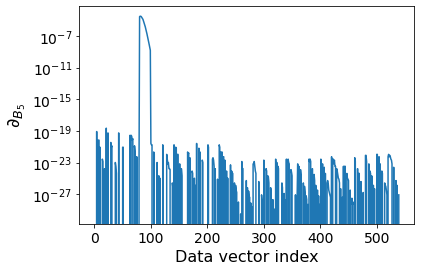

In [20]:
bias_5_deriv = numerical_deriv('bias_5', 0.01)

plt.plot(bias_5_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_5}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

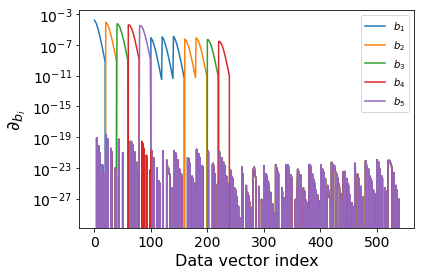

In [21]:
plt.plot(bias_1_deriv, label = '$b_1$')
plt.plot(bias_2_deriv, label = '$b_2$')
plt.plot(bias_3_deriv, label = '$b_3$')
plt.plot(bias_4_deriv, label = '$b_4$')
plt.plot(bias_5_deriv, label = '$b_5$')

plt.yscale('log')
plt.ylabel('$\partial_{b_i}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()

plt.show()

# Start on Fisher matrix calculation
### Load in covariance matrix, multiply deriv by inv cov by deriv
#### Note : (omeg_c, omeg_b, h, sig8, n_s, bias, sig0, mu0, w0l, w_a) is order we will be constructing this in

In [22]:
inv_cov = np.loadtxt('inv_cov_matrix') #read in the saved inverse covariance matrix
mask = np.loadtxt('scale_mask')
print(np.shape(mask))
print(np.shape(inv_cov))
print(inv_cov)

(705,)
(540, 540)
[[ 5.93063017e+18 -2.97754813e+16 -4.66205760e+16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.97754813e+16  1.27555122e+19 -7.41638895e+16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.66205760e+16 -7.41638895e+16  2.70979734e+19 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [23]:
#initialise a numpy array for our fisher matrices for h = 10^-2 and the LSST fisher matrix
fisher = np.zeros(shape = (14,14))

fisher_LSST_Y1 = np.array([[4.321685e+05, 2.754616e+05, 5.992140e+04, -1.992358e+04, -4.473057e+03, -2.164983e+05, 5.264462e+04],
[2.754616e+05, 2.082198e+05, 2.691262e+04, -1.379929e+04, -3.407022e+03, -7.745383e+04, 1.946493e+04],
[5.992140e+04, 2.691262e+04, 2.414847e+04, -6.937346e+02, -1.056892e+02, -6.207807e+04, 1.576508e+04],
[-1.992358e+04, -1.379929e+04, -6.937346e+02, 1.395740e+03, 3.162361e+02, 4.976017e+03, -1.248729e+03],
[-4.473057e+03, -3.407022e+03, -1.056892e+02, 3.162361e+02, 8.081758e+01, 9.051103e+02, -2.218407e+02],
[-2.164983e+05, -7.745383e+04, -6.207807e+04, 4.976017e+03, 9.051103e+02, 3.877220e+05, -6.499201e+04],
[5.264462e+04, 1.946493e+04, 1.576508e+04, -1.248729e+03, -2.218407e+02, -6.499201e+04, 1.565908e+04]])

In [24]:
#Construct a dictionary that we can iterate through that contains our derivative data vectors
derivatives = [Omega_c_deriv,\
               Omega_b_deriv,\
               h_deriv,\
               A_s_norm_deriv,\
               n_s_deriv,\
               bias_1_deriv,\
               bias_2_deriv,\
               bias_3_deriv,\
               bias_4_deriv,\
               bias_5_deriv,\
               sig_0_deriv,\
               mu_0_deriv,\
               w0_deriv,\
               wa_deriv]

In [27]:
#apply mask to derivative vector (cuts down certain scales)
for i in range(len(derivatives)):
    for j in range(540):
        derivatives[i][j] = derivatives[i][j]*mask[j]

In [28]:
#Script to construct the fisher matrix, looping over the parameter derivatives

for i in range(len(derivatives)):
    for j in range(len(derivatives)):
        fisher[i][j] = np.matmul(derivatives[i], (np.matmul(inv_cov, derivatives[j])))

In [30]:
print(np.shape(fisher))
print(np.shape(fisher_LSST_Y1))

(14, 14)
(7, 7)


In [31]:
#eliminate rows and columns associated with modified gravity parameters in the fisher matrix 
#(treating the two as constant essentially) store in a new variable

fisher_no_mg = np.delete(fisher, 10, 0)
fisher_no_mg = np.delete(fisher_no_mg, 10, 1)
fisher_no_mg = np.delete(fisher_no_mg, 10, 0)
fisher_no_mg = np.delete(fisher_no_mg, 10, 1)


print(np.shape(fisher_no_mg))

(12, 12)


In [32]:
#1 sigma standard deviations between for each parameter in the original fisher matrix
sig_1_dev = []
for i in range(14):
    sig_1_dev.append((np.sqrt(fisher[i][i]))**(-1))
    
print(sig_1_dev)

[1.4556665197388909e-06, 5.217768472697778e-06, 7.946319146180482e-07, 1.6227622920865803e-06, 1.7394061113323917e-06, 8.637613791786537e-07, 8.586665082810015e-07, 1.0126517660185433e-06, 1.1495921898238805e-06, 1.5953995980775516e-06, 0.0015402755306122447, 8.971460752230284e-05, 6.372886451022511e-06, 0.00010498506619103171]


In [33]:
#parameter covariance matrix is inverse of the fisher matrix so calculate parameter covariances for each fisher
param_cov = np.linalg.inv(fisher)

param_cov_LSST_Y1 = np.linalg.inv(fisher_LSST_Y1)

param_cov_no_mg = np.linalg.inv(fisher_no_mg)

In [34]:
#check that the standard deviations are all positive in the regular parameter covariance matrix
pos_or_neg = []

for i in range(8):
    if param_cov[i][i] < 0:
        pos_or_neg.append('neg')
    else:
        pos_or_neg.append('pos')
        
print(pos_or_neg)

['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']


In [38]:
print(np.linalg.eig(param_cov)[0]) #ensure that all eigenvalues of the parameter covariance matrix are positive

[5.88780764e-02 1.30875118e-04 3.22200079e-05 1.35443247e-07
 3.90083386e-09 3.03676239e-09 3.49315920e-10 2.44840656e-10
 3.76428220e-12 2.36904100e-12 1.13036559e-12 3.15897617e-13
 8.36974458e-13 5.85325470e-13]


In [39]:
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist

In [40]:
#params_fiducial = {'Omega_c': 0.27,\
 #                          'Omega_b': 0.045,\
  #                         'h': 0.67,\
   #                        'A_s_norm': 2.1,\
    #                       'n_s': 0.96,\
     #                      'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
      #                     'w0': -0.9,\
        #                   'mu_0': 0,\
       #                    'sigma_0': 0 }

param_mean = [0.27, 0.045, 0.67, 2.1, 0.96, 1.562362, 1.732963, 1.913252, 2.100644, 2.293210, 0, 0, -0.9, 0.0]


param_names = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'B1', 'B2', 'B3', 'B4', 'B5,' 'Sigma_0', 'mu_0', 'w0', 'wa']

labels = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'B^{1}', r'B^{2}', r'B^{3}', r'B^{4}', r'B^{5}', r'\Sigma_{0}', r'\mu_{0}', r'w_{0}', r'w_{a}']


gauss = GaussianND(param_mean, param_cov, labels = labels, names = param_names)

In [41]:
g = plots.get_subplot_plotter() #subplotter instance for chainconsumer (used for triangle plots)

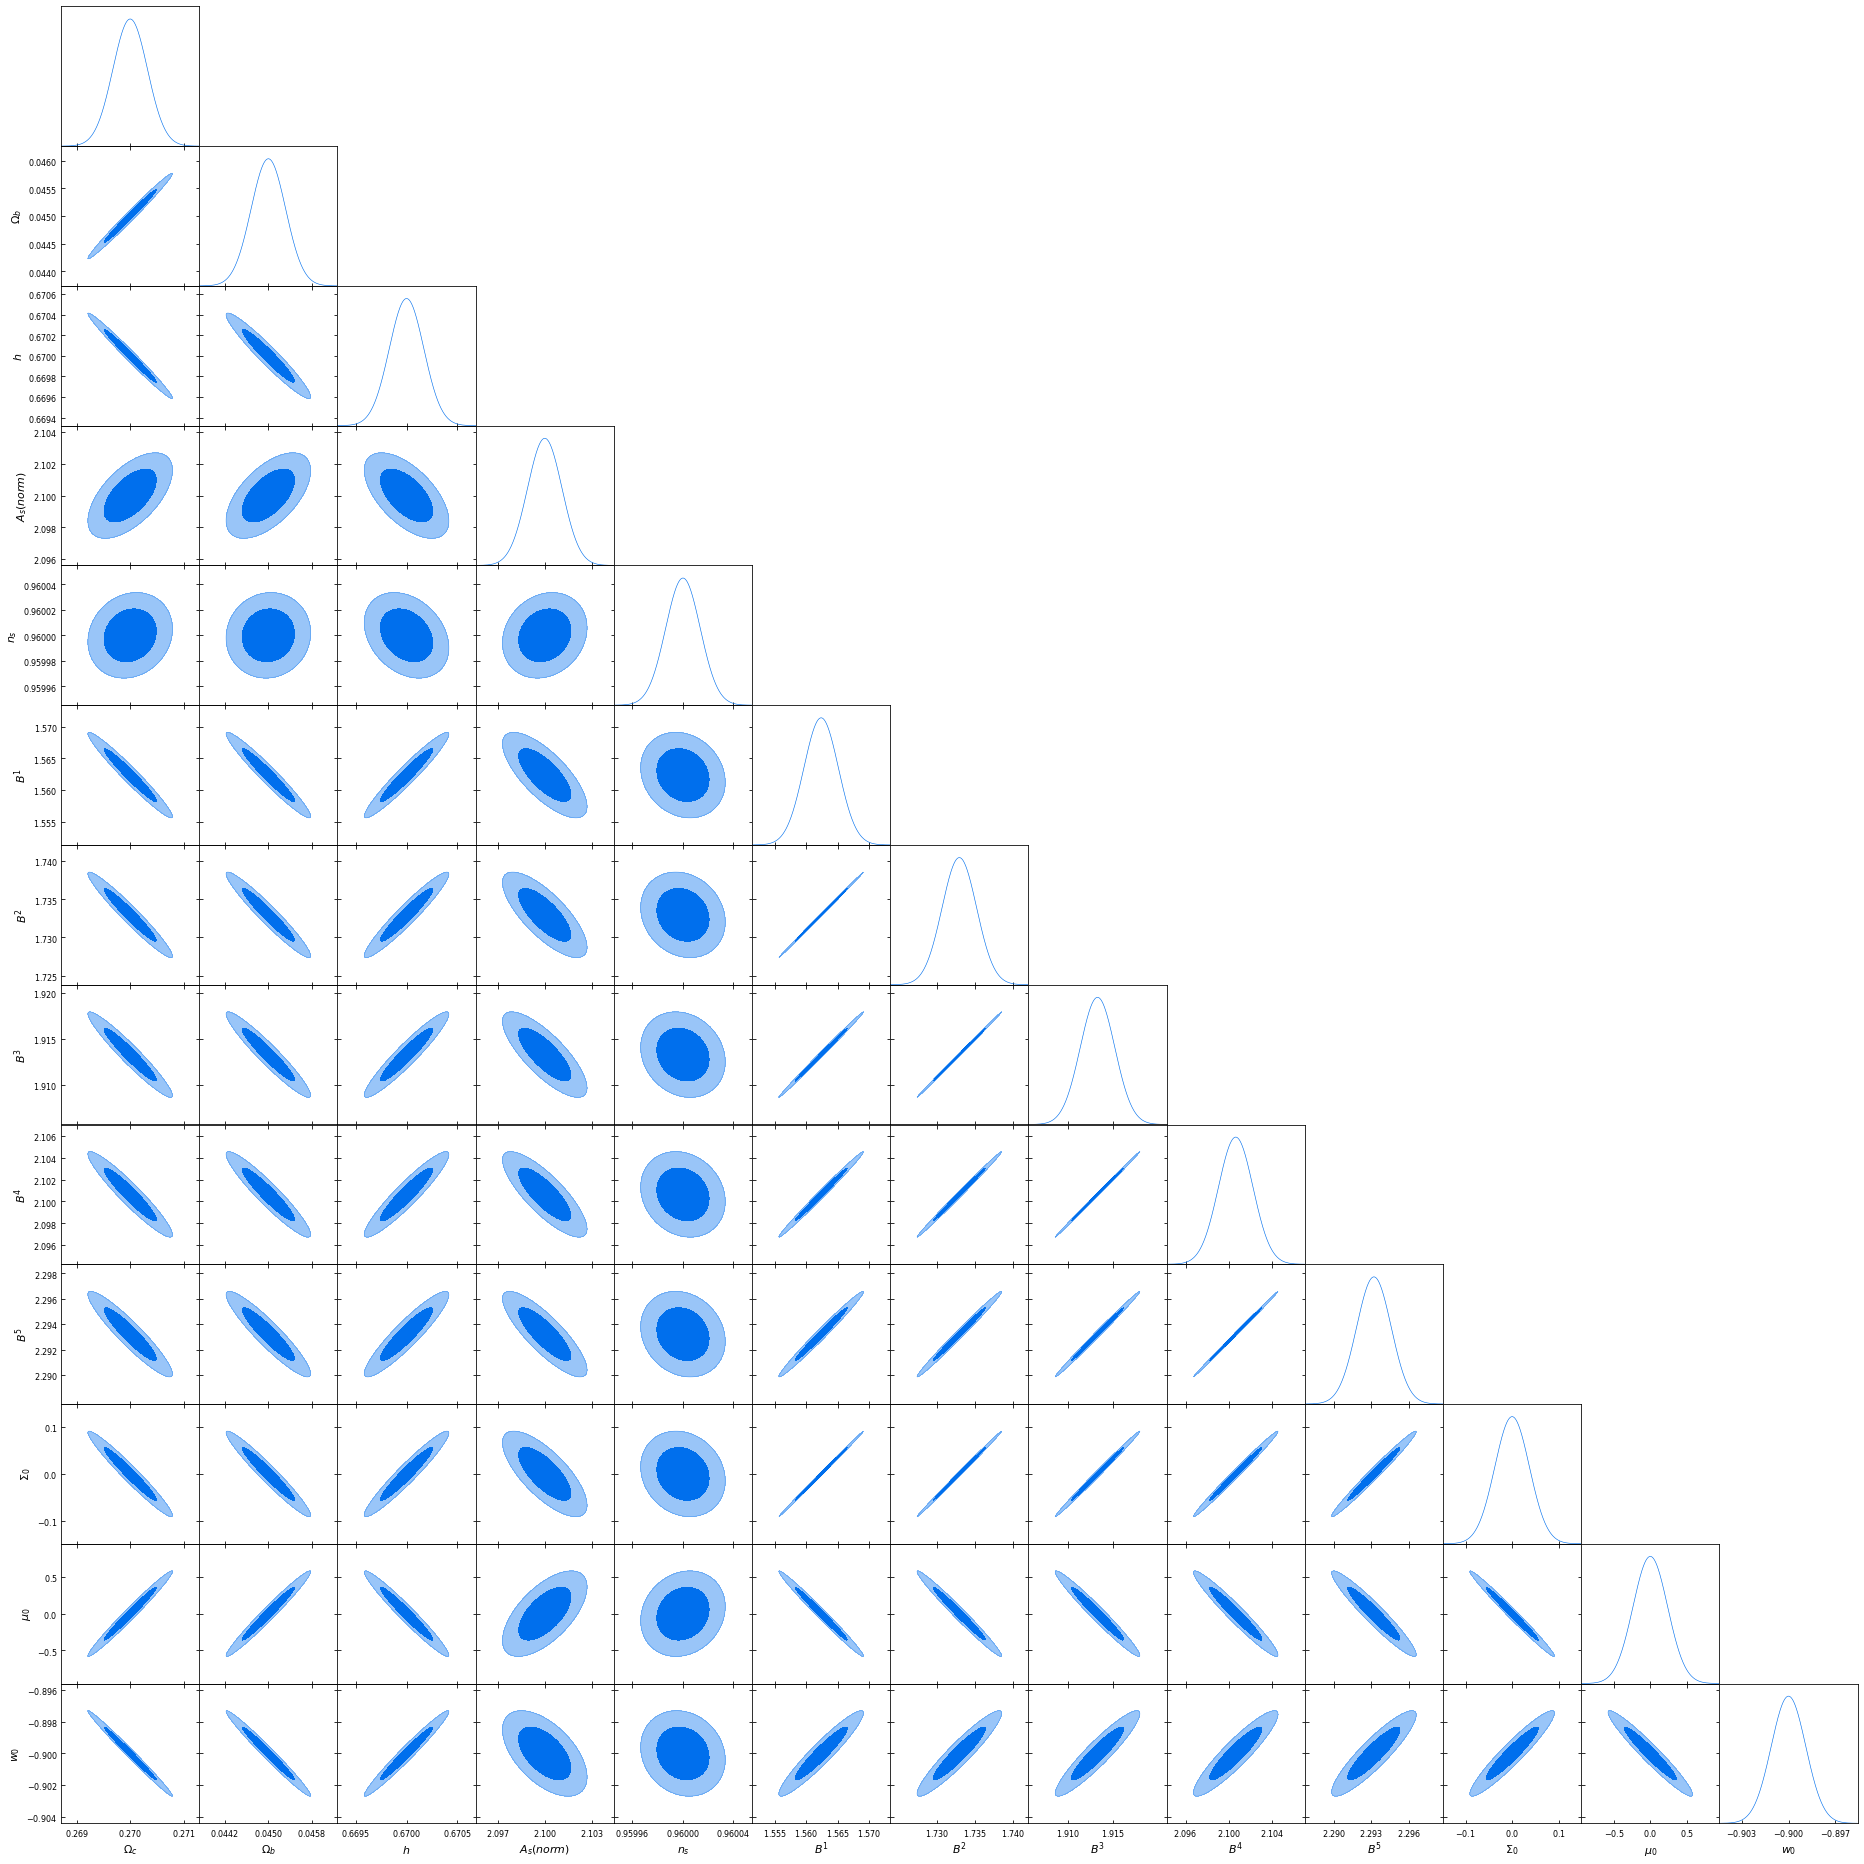

In [42]:
g = plots.get_subplot_plotter()
g.triangle_plot(gauss, filled = True)

In [43]:
param_names_LSST = ['Omega_m', 'sigma8', 'n_s', 'w0', 'wa', 'omega_b', 'h0']
labels_LSST = [r'\Omega_{m}', r'\sigma_{8}', r'n_{s}', r'w_{0}', r'w_{a}', r'\Omega_{b}', r'h_{0}']
mean_LSST = [0.27, 0.83, 0.96, -0.9, 0.0, 0.0450, 0.67]

gauss_LSST = GaussianND(mean_LSST ,param_cov_LSST_Y1, labels = labels_LSST, names = param_names_LSST)

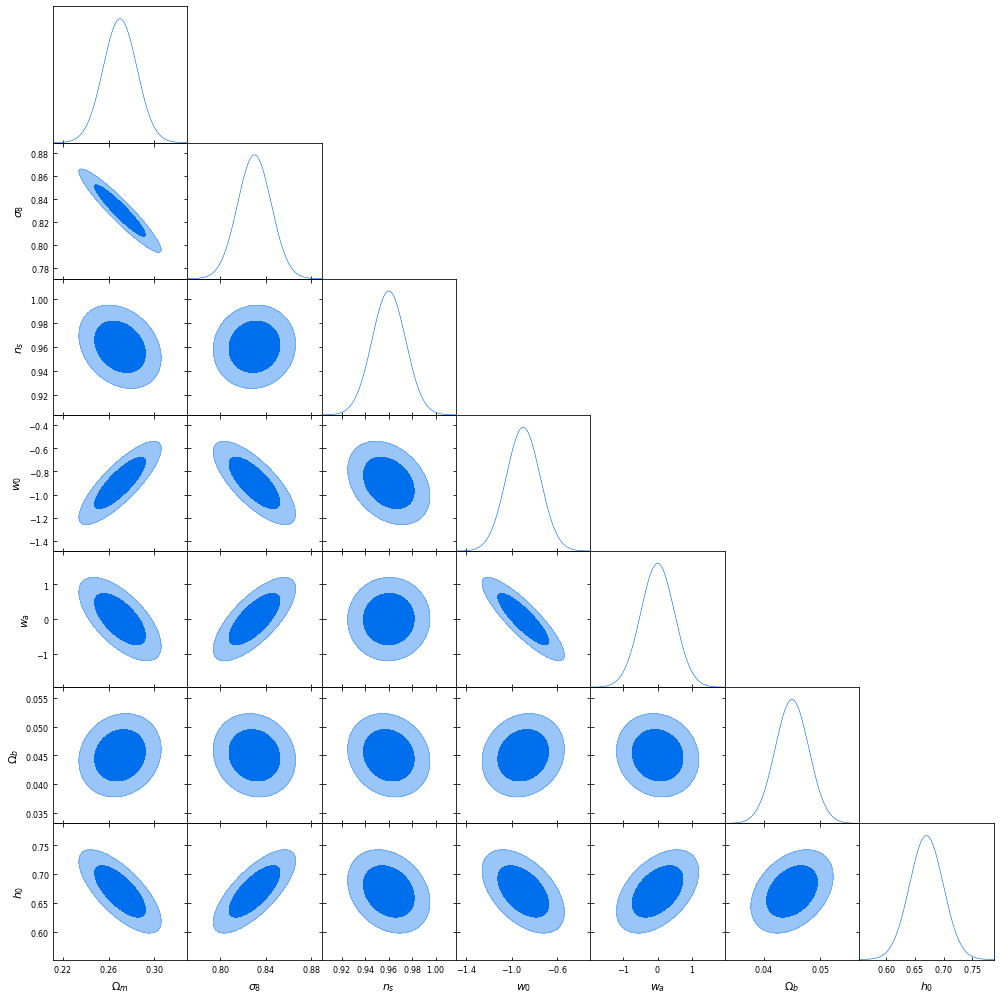

In [44]:
g.triangle_plot(gauss_LSST, filled = True)

In [45]:
#params_fiducial = {'Omega_c': 0.27,\
 #                          'Omega_b': 0.045,\
  #                         'h': 0.67,\
   #                        'A_s_norm': 2.1,\
    #                       'n_s': 0.96,\
     #                      'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
      #                     'w0': -0.9,\
        #                   'mu_0': 0,\
       #                    'sigma_0': 0 }

param_mean_no_mg = [0.27, 0.045, 0.67, 2.1, 0.96, 1.562362, 1.732963, 1.913252, 2.100644, 2.293210, -0.9, 0.0]


param_names_no_mg = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'B1', 'B2', 'B3', 'B4', 'B5', 'w0', 'wa']

labels_no_mg = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'B^{1}', r'B^{2}', r'B^{3}', r'B^{4}', r'B^{5}', r'w_{0}', r'w_{a}']


gauss_no_mg=GaussianND(param_mean_no_mg, param_cov_no_mg, labels = labels_no_mg, names = param_names_no_mg)

In [47]:
#now clean up the no mg forecast by getting rid of bias constraints
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

print(np.shape(param_cov_no_mg_no_bias))

(7, 7)


In [48]:
param_mean_no_mg_no_bias = [0.27, 0.045, 0.67, 2.1, 0.96, -0.9, 0.0]


param_names_no_mg_no_bias = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'w0', 'wa']

labels_no_mg_no_bias = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'w_{0}', r'w_{a}']


gauss_no_mg_no_bias = GaussianND(param_mean_no_mg_no_bias,\
                                 param_cov_no_mg_no_bias,\
                                 labels = labels_no_mg_no_bias,\
                                 names = param_names_no_mg_no_bias)

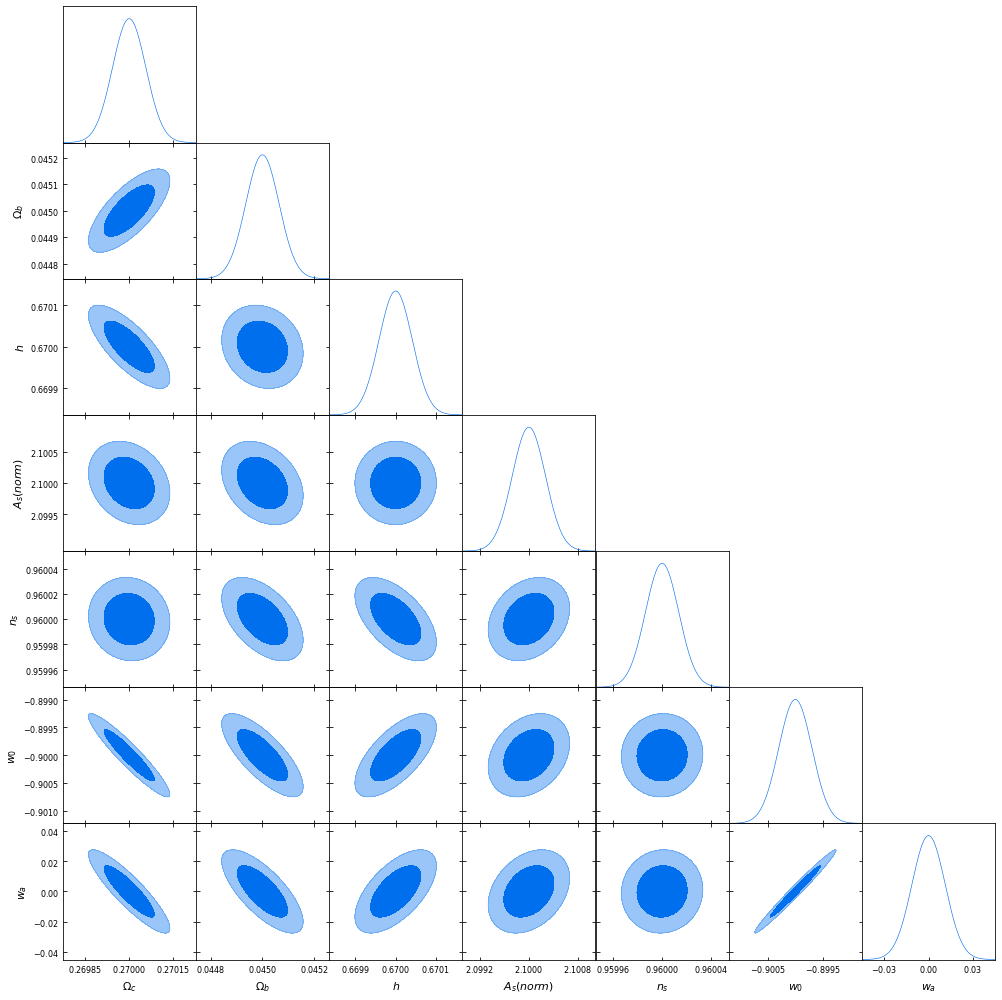

In [49]:
g.triangle_plot(gauss_no_mg_no_bias, filled = True)